# Решающие деревья и решающие леса. Отбор признаков. Линейная регрессия.

# 1. Решающие деревья

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевая переменная — расстояние от объекта до точки (0, 0).

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import pylab as plt

Populating the interactive namespace from numpy and matplotlib


Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей красивой визуализации

In [2]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

Сгенерируем выборку

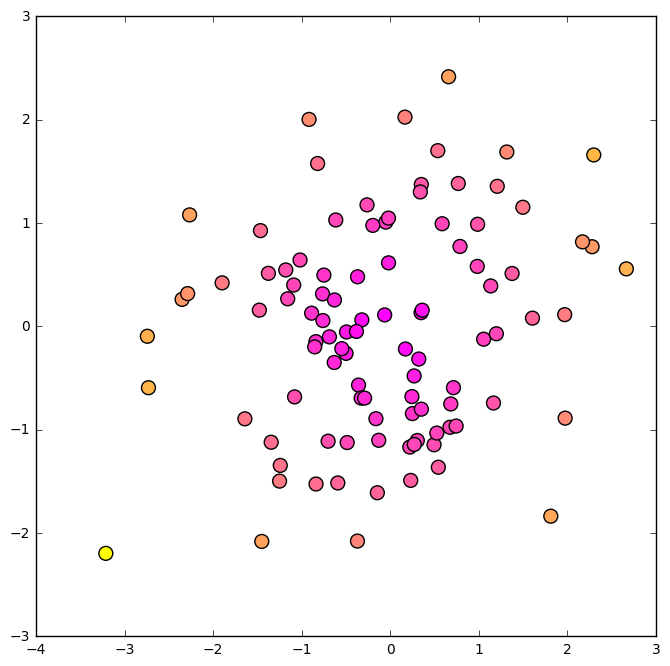

In [3]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

In [4]:
from sklearn.tree import DecisionTreeRegressor

Обучим дерево на сгенерированных данных и предскажем ответы для каждой точки решетки

[[-4.21213486 -3.19595841]
 [-4.20213486 -3.19595841]
 [-4.19213486 -3.19595841]
 ..., 
 [ 3.63786514  3.41404159]
 [ 3.64786514  3.41404159]
 [ 3.65786514  3.41404159]]


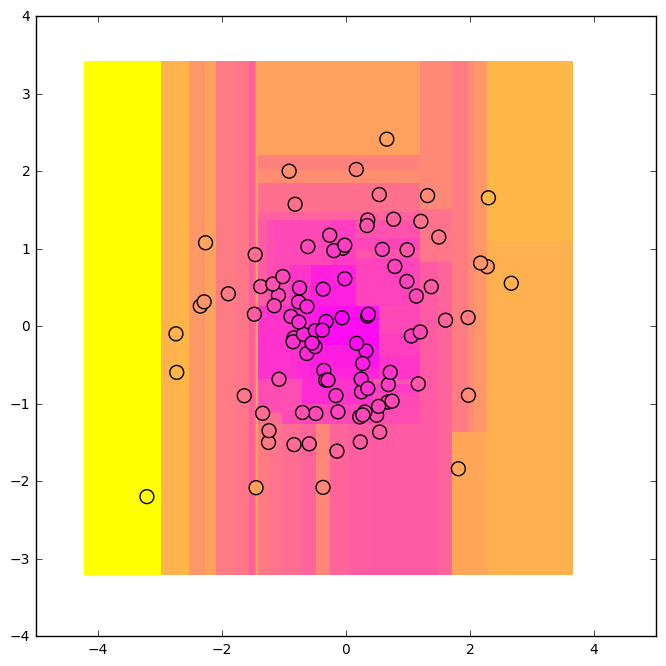

In [5]:
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)
print np.c_[xx.ravel(), yy.ravel()]

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

Посмотрим как будут выглядеть разделяющая поверхность в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

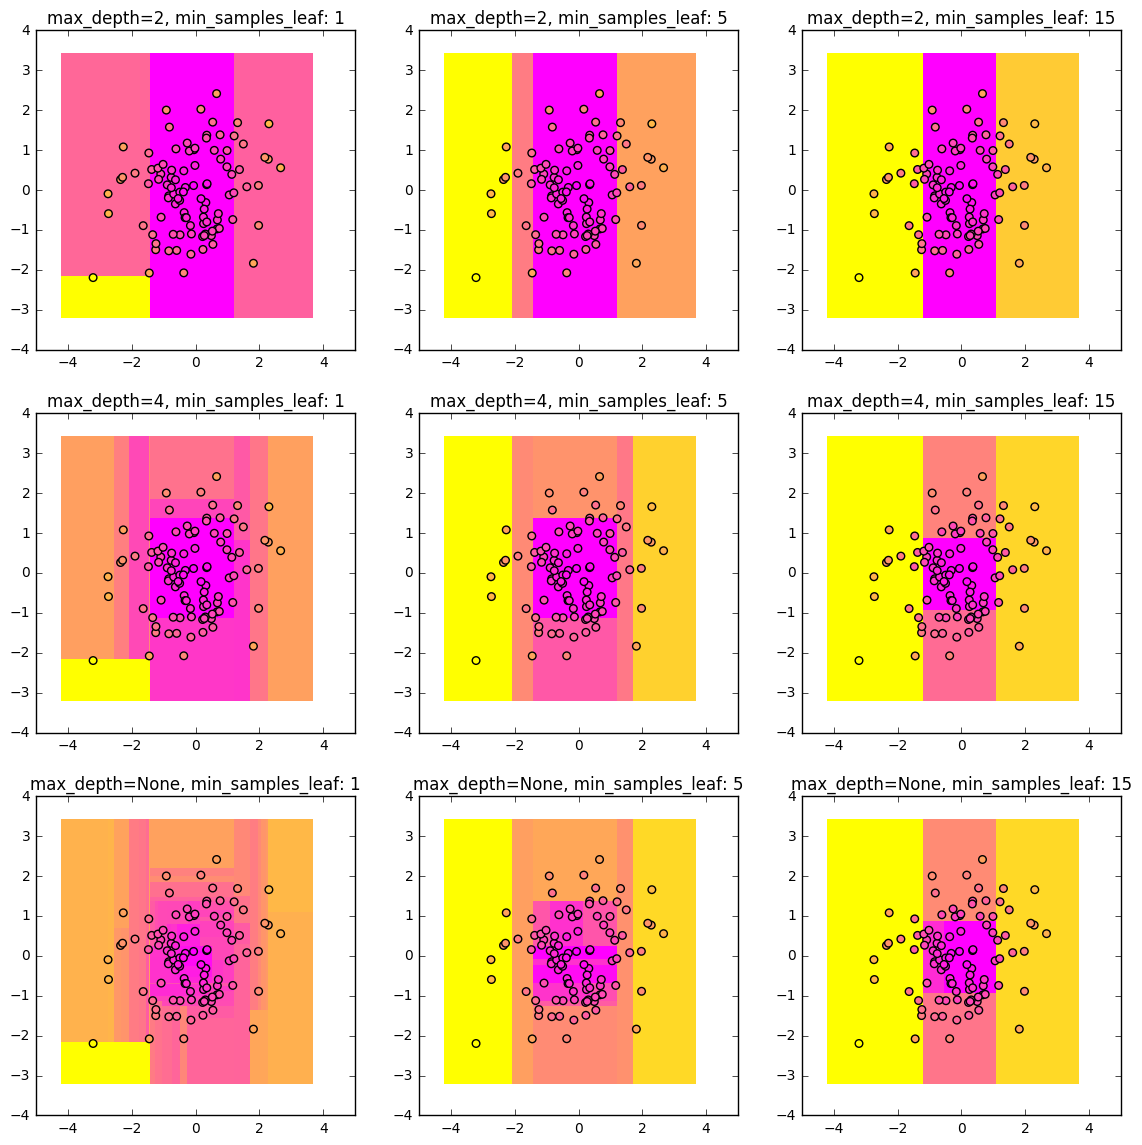

In [6]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([1, 5, 15]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

- Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению.

## Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.
Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


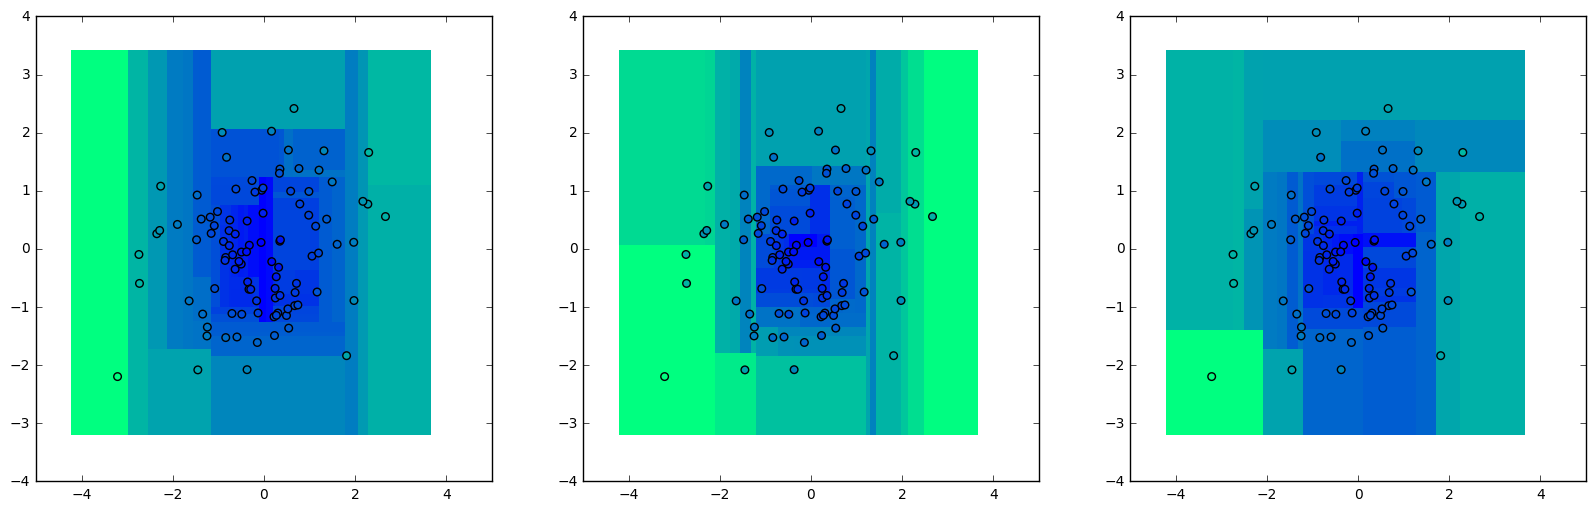

In [7]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indices = np.random.randint(data_x.shape[0], size=(data_x.shape[0] * 0.9))
    clf.fit(data_x[indices], data_y[indices])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter')

## Подбор параметров

Посмотрим на качество дерева в зависимости от параметров на одном из стандартных наборов данных - Бостонском датасете.

In [8]:
from sklearn.datasets import load_boston

In [9]:
data = load_boston()
print data.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [10]:
X_full = data.data
y_full = data.target

print X_full[:3]

[[  6.32000000e-03   1.80000000e+01   2.31000000e+00   0.00000000e+00
    5.38000000e-01   6.57500000e+00   6.52000000e+01   4.09000000e+00
    1.00000000e+00   2.96000000e+02   1.53000000e+01   3.96900000e+02
    4.98000000e+00]
 [  2.73100000e-02   0.00000000e+00   7.07000000e+00   0.00000000e+00
    4.69000000e-01   6.42100000e+00   7.89000000e+01   4.96710000e+00
    2.00000000e+00   2.42000000e+02   1.78000000e+01   3.96900000e+02
    9.14000000e+00]
 [  2.72900000e-02   0.00000000e+00   7.07000000e+00   0.00000000e+00
    4.69000000e-01   7.18500000e+00   6.11000000e+01   4.96710000e+00
    2.00000000e+00   2.42000000e+02   1.78000000e+01   3.92830000e+02
    4.03000000e+00]]


In [11]:
X_full.shape

(506L, 13L)

In [12]:
y_full[:10]

array([ 24. ,  21.6,  34.7,  33.4,  36.2,  28.7,  22.9,  27.1,  16.5,  18.9])

In [13]:
from sklearn.cross_validation import train_test_split
X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=100, 
                                        random_state=241)

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
from sklearn.cross_validation import KFold, cross_val_score
cv = KFold(X.shape[0], shuffle=True, random_state=241)

In [15]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=241)
print -cross_val_score(regr, X, y, cv=cv, 
                       scoring='mean_squared_error').mean()

24.4502234931


C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [16]:
regr.fit(X, y)
regr.tree_

In [17]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(random_state=241)
print cross_val_score(regr, X, y, cv=cv, 
                       scoring='r2').mean()

0.705238866424


In [18]:
from sklearn.grid_search import GridSearchCV
gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={'max_features': [None, 'log2', 'sqrt'], 
                              'max_depth': [2, 4, 6, 8, 10, 20, 50]},
                  cv=cv,
                  scoring='r2')
gs.fit(X, y)
gs.grid_scores_

C:\Program Files\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[mean: 0.60310, std: 0.07101, params: {'max_features': None, 'max_depth': 2},
 mean: 0.42140, std: 0.06060, params: {'max_features': 'log2', 'max_depth': 2},
 mean: 0.42140, std: 0.06060, params: {'max_features': 'sqrt', 'max_depth': 2},
 mean: 0.73879, std: 0.11251, params: {'max_features': None, 'max_depth': 4},
 mean: 0.38099, std: 0.12633, params: {'max_features': 'log2', 'max_depth': 4},
 mean: 0.38099, std: 0.12633, params: {'max_features': 'sqrt', 'max_depth': 4},
 mean: 0.76242, std: 0.03348, params: {'max_features': None, 'max_depth': 6},
 mean: 0.51970, std: 0.05065, params: {'max_features': 'log2', 'max_depth': 6},
 mean: 0.51970, std: 0.05065, params: {'max_features': 'sqrt', 'max_depth': 6},
 mean: 0.73660, std: 0.00573, params: {'max_features': None, 'max_depth': 8},
 mean: 0.59787, std: 0.05413, params: {'max_features': 'log2', 'max_depth': 8},
 mean: 0.59787, std: 0.05413, params: {'max_features': 'sqrt', 'max_depth': 8},
 mean: 0.72800, std: 0.00374, params: {'max_feat

In [19]:
from sklearn.grid_search import GridSearchCV
gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={'max_features': [None, 'log2', 'sqrt'],
                              'max_depth': [2, 4, 6, 8, 10, 20, 50], 
                              'min_samples_leaf': range(1, 20)},
                  cv=cv,
                  scoring='r2')
gs.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=406, n_folds=3, shuffle=True, random_state=241),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=241, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, 20, 50], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

In [20]:
gs.best_score_

0.775856892150106

In [21]:
for z in gs.grid_scores_:
    if z.mean_validation_score == gs.best_score_:
        print z

mean: 0.77586, std: 0.03204, params: {'max_features': None, 'max_depth': 6, 'min_samples_leaf': 2}


# Решающие деревья для классификации¶

Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

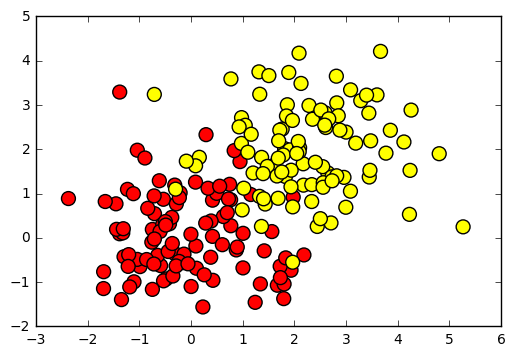

In [22]:
n = 100
a = np.random.normal(loc=0, size=(n, 2))
b = np.random.normal(loc=2, size=(n, 2))

data_x = np.vstack([a, b])
data_y = np.hstack([np.zeros(n), np.ones(n)])

scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='autumn')

Попробуем разделить эти два класса, обучив решающее дерево. Визуализируем полученную границу разделения класссов.

(-3.3731029751834325, 6.2568970248163627)

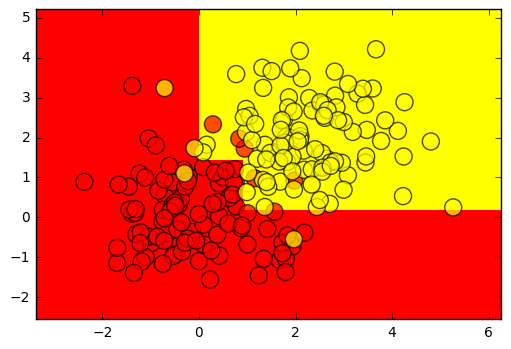

In [23]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(min_samples_leaf=5)
clf.fit(data_x, data_y)
xx, yy = get_grid(data_x)
predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
pcolormesh(xx, yy, predicted, cmap='autumn')
scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=150, cmap='autumn', alpha=0.7)
ylim([yy.min(),yy.max()])
xlim([xx.min(),xx.max()])

# Задание.
По аналогии с GridSearchCV для DecisionTreeRegressor используйте GridSearchCV для DecisionTreeClassifier, чтобы посмотреть, как различные параметры влияют на качество классификации.

возьмите cv=5 (число фолдов), параметры 'min_samples_leaf': [1, 3, 7, 20], 'max_depth': [2, 3, 5, 10]

In [1]:
#Your code here

## 2. Решающий лес

Посмотрим, какое качество можно получить при использовании решающего леса. Будем делать предсказания на Boston dataset.

In [25]:
regr = DecisionTreeRegressor()
print cross_val_score(regr, X, y, cv=cv,
                       scoring='r2').mean()

0.747686046454


In [26]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=10)
print cross_val_score(regr, X, y, cv=cv,
                       scoring='r2').mean()

0.830618314683


In [27]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=100)
print cross_val_score(regr, X, y, cv=cv,
                       scoring='r2').mean()

0.850970815689


In [28]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=300)
print cross_val_score(regr, X, y, cv=cv,
                       scoring='r2').mean()

0.848329783755


In [29]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=500)
print cross_val_score(regr, X, y, cv=cv,
                       scoring='r2').mean()

0.850443617209


In [30]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=1000)
print cross_val_score(regr, X, y, cv=cv,
                       scoring='r2').mean()

0.849248906738


# Задание.
Постройте график качества классификации на кросс-валидации в зависимости от числа деревьев.

На каждой итерации цикла обучайте регрессор командой regr = ... и добавляйте в список Scores число cross_val_score:
Scores.append(cross_val_score(...))

In [99]:
Ntrees = np.arange(5,500,20)
Scores = []

for elem in Ntrees:
    #Your code here
    
plot(Scores)

# 3. Отбор признаков

Мы можем сократить количество исходных признаков несколькими способами. Первый - на основе корреляции с целевой переменной.

(506L, 14L)


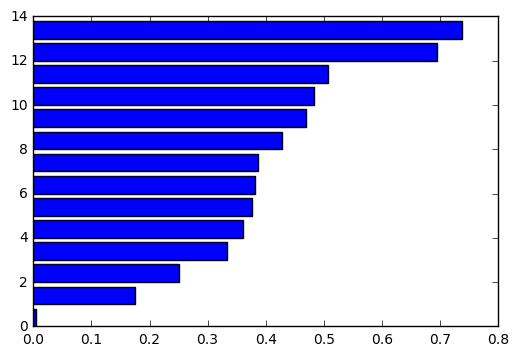

In [32]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

ds = load_boston()
X_, y = ds.data, ds.target
#X - информация о домах
#y - стоимость домов

#добавим "мешающий" признак
X = np.zeros((X_.shape[0],X_.shape[1]+1))
X[:,:-1] = X_
curr = np.random.randint(2, size=506)
curr = np.array([elem if elem > 0 else elem-1 for elem in curr])
X[:,-1] = X[:,0]*curr
print X.shape

indices = np.arange(len(y))
np.random.shuffle(indices)
X = X[indices, :]
y = y[indices]

features_ind = np.arange(X.shape[1])
corrs = np.abs([pearsonr(X[:, i], y)[0] for i in features_ind])
importances_sort = np.argsort(corrs)
plt.barh(features_ind, corrs[importances_sort])
X = X[:, importances_sort]

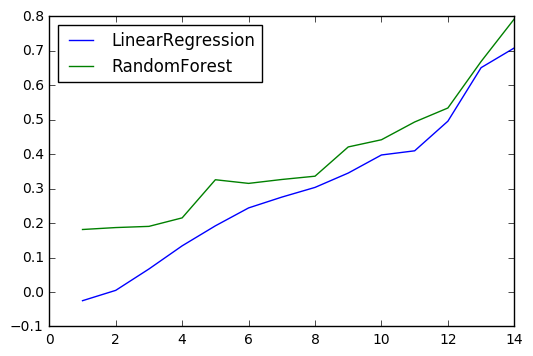

In [33]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

features_counts = np.arange(1, X.shape[1] + 1)

def scores_by_features_count(reg):
    scores = []
    for features_part in features_counts:
        X_part = X[:, :features_part]
        scores.append(cross_val_score(reg, X_part, y).mean())
    return scores
    
plt.figure()
linreg_scores = scores_by_features_count(LinearRegression())
plt.plot(features_counts, linreg_scores, label='LinearRegression')
rf_scores = scores_by_features_count(RandomForestRegressor(n_estimators=100, max_depth=3))
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best')

Еще один способ отбора признаков - с помощью метода SelectKBest. Метод оставляет k признаком с самыми большими значениями некоторой статистики, которую используем для отбора. Приведем пример, в качестве статистики использующий совместную информацию признаков. Для признаков X и Y она задается следующей формулой:
$$I(X;Y)=\sum _{y\in Y}\sum _{x\in X}p(x,y)\log {\left({\frac {p(x,y)}{p(x)\,p(y)}}\right)}$$

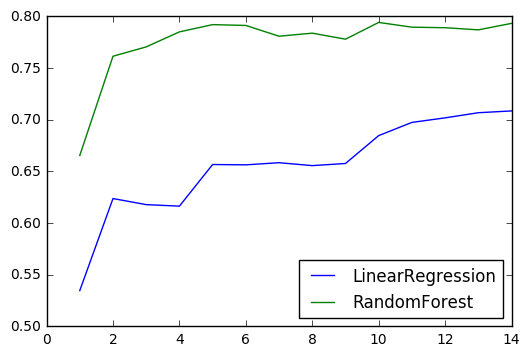

In [34]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression

def scores_by_kbest_count(reg):
    scores = []
    for features_part in features_counts:
        X_new = SelectKBest(mutual_info_regression, k=features_part).fit_transform(X, y)
        scores.append(cross_val_score(reg, X_new, y).mean())
    return scores
    
#Plot results of SelectKBest
#Your code is here

plt.figure()
linreg_scores = scores_by_kbest_count(LinearRegression())
plt.plot(features_counts, linreg_scores, label='LinearRegression')
rf_scores = scores_by_kbest_count(RandomForestRegressor(n_estimators=100, max_depth=3))
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best')


Рекурсивный отбор признаков
Выбираем алгоритм (estimator), применяем его, и он в результате своей работы присваивает веса всем признакам. Затем откидываем наименее важные признаки и снова запускаем estimator и т.д., до тех пор, пока не останется заранее заданное число признаков.

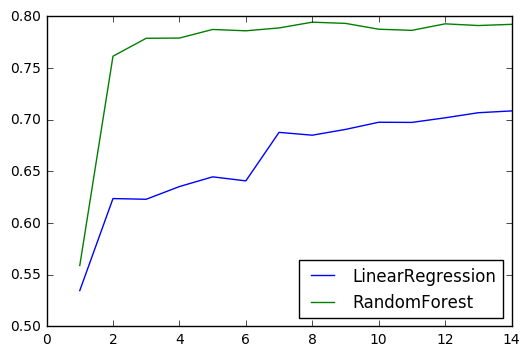

In [35]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

def scores_by_rfe_count(reg):
    scores = []
    for features_part in features_counts:
        
        est = RandomForestRegressor(n_estimators=10, max_depth=3)
        #Try another estimators. Which one is the best?
        
        X_rfe = RFE(estimator=est, n_features_to_select=features_part, step=1).fit_transform(X, y)
        scores.append(cross_val_score(reg, X_rfe, y).mean())
    return scores
    
#Plot results of RFE
#Your code is here

plt.figure()
linreg_scores = scores_by_rfe_count(LinearRegression())
plt.plot(features_counts, linreg_scores, label='LinearRegression')
rf_scores = scores_by_rfe_count(RandomForestRegressor(n_estimators=100, max_depth=3))
plt.plot(features_counts, rf_scores, label='RandomForest')
plt.legend(loc='best')

Мы видим, что последние два метода при использовании RandomForestRegressor позволяют нам оставить довольно мало признаков, что существенно ускоряет нас.

# Задание.
Поработайте с датасетом wine_data. 

1) Посчитайте качество DecisionTreeClassifier и RandomForestClassifier на кросс-валидации.

2) Попробуйте уменьшить число признаков с помощью какого-либо метода отбора признаков. Добейтесь увеличения качества RandomForestClassifier на кросс-валидации.

In [36]:
data = pd.read_csv('wine_data.csv', header=None)
print data.shape
data.head()

(178, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [37]:
y = data[0].as_matrix()
X = data.drop(0, axis=1).as_matrix()
print X.shape, y.shape

(178L, 13L) (178L,)


In [38]:
#Your code here



# 4. Линейная регрессия

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['indices', 'plt', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


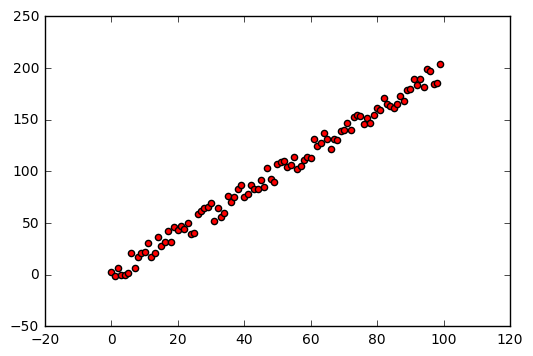

In [39]:
%pylab inline

x = np.arange(100)

#добавление шума
noise = np.random.randint(low = -10, high = 10, size = 100)
y = 2*x + noise

plt.scatter(x, y, c = 'r')

MSE: 37.0901810981
R2: 0.988788478064


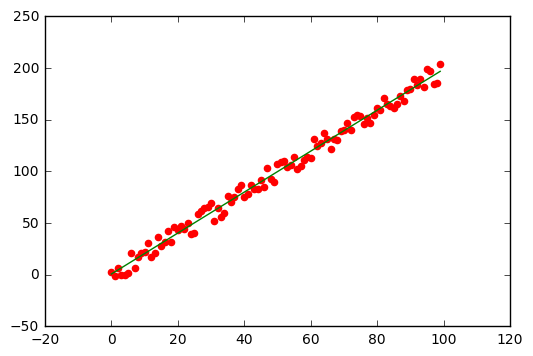

In [40]:
from sklearn.linear_model import LinearRegression

X_train = x.reshape(-1,1)
y_train = y

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

plt.scatter(x, y_train, color = 'r')
plt.plot(x, y_pred, color = 'g')

from sklearn.metrics import mean_squared_error, r2_score
print 'MSE:', mean_squared_error(y_train, y_pred)
print 'R2:', r2_score(y_train, y_pred)

In [41]:
# добавление выбросов
for i in np.random.randint(1, x.shape[0],size = 5, ):
    x[i,] = x.mean()+np.random.randint(100, 200)

# Задание.
Обучите линейную регрессию на новых данных (с добавленными выбросами) - ровно так же, как сделано выше.

In [2]:
#Your code here

# Задание.
Примените к BostonDataset линейную регрессию. Сравните ее качество на кросс-валидации с качеством DecisionTreeRegressor и RandomForestRegressor.
Какой алгоритм работает лучше?

In [ ]:
regr = #your algroithm here
cv = KFold(data_x.shape[0], shuffle=True, random_state=241)

print cross_val_score(regr, data_x, data_y, cv=cv, scoring='r2').mean()

#Try another algorithms